In [1]:
# Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

fatal: destination path 'neurogym' already exists and is not an empty directory.
/Users/edatkinson/4th Year/CogAI/Assessment/neurogym
Obtaining file:///Users/edatkinson/4th%20Year/CogAI/Assessment/neurogym
  Preparing metadata (setup.py) ... done
  Attempting uninstall: neurogym
    Found existing installation: neurogym 0.0.2
    Uninstalling neurogym-0.0.2:
      Successfully uninstalled neurogym-0.0.2
  Running setup.py develop for neurogym


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
import gym
from torch.nn import functional as F
import math
import neurogym as ngym
import torch.nn.init as init
import scipy.spatial


/opt/anaconda3/lib/python3.12/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


In [2]:
import torch
import torch.nn as nn

class MultiTaskLeakyRNN(nn.Module):
    """Leaky RNN with distinct task-specific output layers."""
    def __init__(self, input_dim, hidden_dim, task_outputs, timestep=None):
        """
        Parameters:
            input_dim: int, input dimension size
            hidden_dim: int, hidden layer dimension size
            task_outputs: list of int, output sizes for each specific task
        """
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.time_constant = 100
        self.decay_factor = timestep / self.time_constant if timestep else 1

        self.input_to_hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden_to_hidden = nn.Linear(hidden_dim, hidden_dim)

        # Output layers specific to tasks
        self.output_layers = nn.ModuleList([nn.Linear(hidden_dim, out_dim) for out_dim in task_outputs])

    def initialize_state(self, inputs):
        batch_dim = inputs.shape[1]
        return (torch.zeros(batch_dim, self.hidden_dim).to(inputs.device),
                torch.zeros(batch_dim, self.hidden_dim).to(inputs.device))

    def step(self, inputs, state):
        """Process one time step of the RNN."""
        prev_state, prev_output = state
        new_hidden = torch.relu(self.input_to_hidden(inputs) + self.hidden_to_hidden(prev_output))
        updated_state = prev_state * (1 - self.decay_factor) + new_hidden * self.decay_factor
        output = torch.relu(updated_state)
        return updated_state, output

    def forward(self, inputs, state=None, task_idx=0):
        """
        Parameters:
            inputs: tensor of shape (sequence_length, batch_size, input_dim)
            state: initial hidden state
            task_idx: int, specifies the task output to use

        Returns:
            task_output: tensor of shape (sequence_length, batch_size, task_outputs[task_idx])
            state: final hidden state
        """
        if state is None:
            state = self.initialize_state(inputs)

        seq_outputs = []
        for t in range(inputs.size(0)):
            state = self.step(inputs[t], state)
            seq_outputs.append(state[1])
        rnn_outputs = torch.stack(seq_outputs, dim=0)

        # Task-specific output layer processing
        task_output = self.output_layers[task_idx](rnn_outputs)
        return task_output, state


class MultiTaskRNNModel(nn.Module):
    """Encapsulates MultiTaskLeakyRNN with task-specific outputs."""
    def __init__(self, input_dim, hidden_dim, task_outputs, timestep=None):
        """
        Parameters:
            input_dim: int, input dimension size
            hidden_dim: int, hidden layer dimension size
            task_outputs: list of int, output sizes for each specific task
        """
        super().__init__()
        self.rnn_core = MultiTaskLeakyRNN(input_dim, hidden_dim, task_outputs, timestep)

    def forward(self, inputs, task_idx):
        """
        Parameters:
            inputs: tensor of shape (sequence_length, batch_size, input_dim)
            task_idx: int, specifies the task being handled

        Returns:
            task_output: tensor of shape (sequence_length, batch_size, task_outputs[task_idx])
            state: final hidden state
        """
        task_output, state = self.rnn_core(inputs, task_idx=task_idx)
        return task_output, state


In [3]:
%%capture
# Import the task from the neurogym library
import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Define the environments
task0 = 'PerceptualDecisionMaking-v0'
task1 = 'GoNogo-v0'

timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Create supervised datasets for each task
dataset0 = ngym.Dataset(task0, env_kwargs=kwargs, batch_size=1, seq_len=seq_len)
dataset1 = ngym.Dataset(task1, env_kwargs=kwargs, batch_size=1, seq_len=seq_len)

# Retrieve environments from the datasets
env0 = dataset0.env
env1 = dataset1.env

# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env1, num_trials=2)

# Define network input and output sizes based on the environments
input_dim0 = env0.observation_space.shape[0]
output_dim0 = env0.action_space.n

input_dim1 = env1.observation_space.shape[0]
output_dim1 = env1.action_space.n

print(input_dim0)
print(input_dim1)

print(output_dim0)
print(output_dim1)


Iteration 10, Task 0, Loss: 1.1196
Iteration 10, Task 1, Loss: 0.7504
Iteration 20, Task 0, Loss: 1.0229
Iteration 20, Task 1, Loss: 0.7091
Iteration 30, Task 0, Loss: 0.9343
Iteration 30, Task 1, Loss: 0.6699
Iteration 40, Task 0, Loss: 0.8649
Iteration 40, Task 1, Loss: 0.6090
Iteration 50, Task 0, Loss: 0.7291
Iteration 50, Task 1, Loss: 0.5556
Iteration 60, Task 0, Loss: 0.6193
Iteration 60, Task 1, Loss: 0.5275
Iteration 70, Task 0, Loss: 0.5924
Iteration 70, Task 1, Loss: 0.3624
Iteration 80, Task 0, Loss: 0.5711
Iteration 80, Task 1, Loss: 0.5356
Iteration 90, Task 0, Loss: 0.5991
Iteration 90, Task 1, Loss: 0.3774
Iteration 100, Task 0, Loss: 0.5972
Iteration 100, Task 1, Loss: 0.4100
Iteration 110, Task 0, Loss: 0.5661
Iteration 110, Task 1, Loss: 0.3525
Iteration 120, Task 0, Loss: 0.4988
Iteration 120, Task 1, Loss: 0.4642
Iteration 130, Task 0, Loss: 0.4650
Iteration 130, Task 1, Loss: 0.3689
Iteration 140, Task 0, Loss: 0.5537
Iteration 140, Task 1, Loss: 0.6354
Iteration 

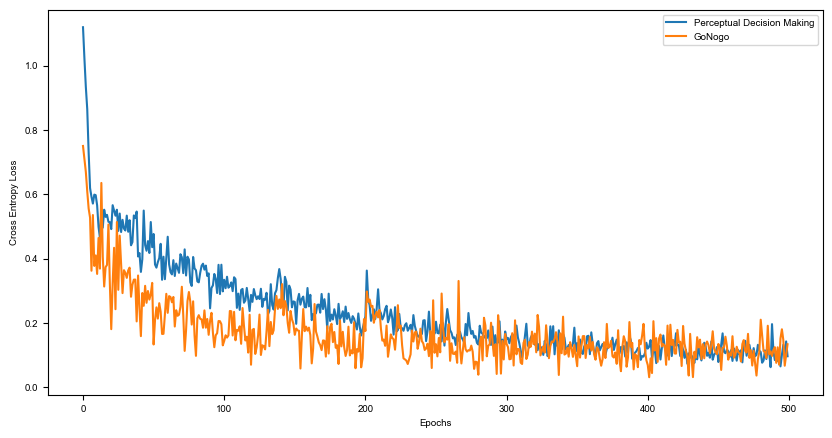

In [5]:
import random
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

# Initialize the model
hidden_dim = 50
task_outputs = [3, 2]  # Task 0: 3 classes, Task 1: 2 classes
model = MultiTaskRNNModel(input_dim=input_dim0, hidden_dim=hidden_dim,
                          task_outputs=task_outputs, timestep=env0.dt)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Alternate datasets
datasets = [dataset0, dataset1]

# Initialize loss trackers
loss_history = {0: [], 1: []}  # Store logged losses for each task
cumulative_loss = {0: 0.0, 1: 0.0}  # Track cumulative loss for each task

# Training parameters
iterations = 5000
log_interval = 10  # How often to log and print average loss

# Training loop
for step in range(iterations):
    # Alternate between tasks or randomize
    task_idx = step % 2  # Alternates tasks; use random.choice([0, 1]) for randomness
    dataset = datasets[task_idx]

    # Fetch inputs and labels for the selected task
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass through the model
    predictions, _ = model(inputs, task_idx=task_idx)
    predictions = predictions.view(-1, task_outputs[task_idx])  # Adjust for the task's output size

    # Compute the loss
    loss = loss_function(predictions, labels)

    # Backward pass
    loss.backward()

    # Update model parameters
    optimizer.step()

    # Update cumulative loss for the current task
    cumulative_loss[task_idx] += loss.item()

    # Log and reset cumulative loss every log_interval
    if (step + 1) % log_interval == 0:
        for tid in [0, 1]:
            avg_loss = cumulative_loss[tid] / (log_interval // 2)  # Divide by half interval
            print(f"Iteration {step+1}, Task {tid}, Loss: {avg_loss:.4f}")
            loss_history[tid].append(avg_loss)  # Log the loss
            cumulative_loss[tid] = 0.0  # Reset cumulative loss

# Plot the learning curves for both tasks
plt.figure(figsize=(10, 5))
plt.plot(loss_history[0], label='Perceptual Decision Making')
plt.plot(loss_history[1], label='GoNogo')
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()


In [6]:
# @title Execute the trained network and log neural activity
plt.rcParams['axes.labelsize'] = 14  # Axis labels
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
plt.rcParams['axes.titlesize'] = 13  # Title font size

env0.reset(no_step=True)
performance = 0
num_trials = 500
neural_activity = {}
coherence_data = []  
trial_data = {}
stimulus_responses = [[], []]  # Responses for ground-truth classes 0 and 1

for trial in range(num_trials):
    env0.new_trial()
    observations, ground_truth = env0.ob, env0.gt

    inputs = torch.from_numpy(observations[:, np.newaxis, :]).type(torch.float)
    predictions, hidden_states = model(inputs, task_idx=0)

    # Evaluate performance
    predictions = predictions.detach().numpy()
    decision = np.argmax(predictions[-1, 0, :])  # Task-specific decision
    is_correct = decision == ground_truth[-1]
    
    print(f'Trial {trial}, Correct: {is_correct}, Decision: {decision}, Ground truth: {ground_truth[-1]}')

    # Log trial information
    trial_info = env0.trial
    trial_info.update({'correct': is_correct, 'decision': decision})
    trial_data[trial] = trial_info

    # Log activity during stimulus period
    hidden_states = hidden_states[0]  
    hidden_states = hidden_states[:, 0].detach().numpy()
    neural_activity[trial] = hidden_states
    
    stimulus_period_activity = hidden_states[env0.start_ind['stimulus']: env0.end_ind['stimulus']]
    stimulus_responses[env0.trial['ground_truth']].append(stimulus_period_activity)

# Calculate and print average performance
average_performance = np.mean([info['correct'] for info in trial_data.values()])
print('Average performance:', average_performance)


Trial 0, Correct: False, Decision: 1, Ground truth: 2
Trial 1, Correct: True, Decision: 1, Ground truth: 1
Trial 2, Correct: True, Decision: 1, Ground truth: 1
Trial 3, Correct: True, Decision: 1, Ground truth: 1
Trial 4, Correct: True, Decision: 1, Ground truth: 1
Trial 5, Correct: True, Decision: 1, Ground truth: 1
Trial 6, Correct: True, Decision: 2, Ground truth: 2
Trial 7, Correct: True, Decision: 2, Ground truth: 2
Trial 8, Correct: True, Decision: 2, Ground truth: 2
Trial 9, Correct: True, Decision: 2, Ground truth: 2
Trial 10, Correct: True, Decision: 1, Ground truth: 1
Trial 11, Correct: True, Decision: 1, Ground truth: 1
Trial 12, Correct: True, Decision: 2, Ground truth: 2
Trial 13, Correct: False, Decision: 2, Ground truth: 1
Trial 14, Correct: True, Decision: 1, Ground truth: 1
Trial 15, Correct: False, Decision: 1, Ground truth: 2
Trial 16, Correct: True, Decision: 2, Ground truth: 2
Trial 17, Correct: True, Decision: 1, Ground truth: 1
Trial 18, Correct: True, Decision: 

In [7]:
# @title Execute the trained network and log neural activity for Task 1
plt.rcParams['axes.labelsize'] = 14  # Axis labels
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick labels
plt.rcParams['axes.titlesize'] = 13  # Title font size

env1.reset(no_step=True)
performance = 0
num_trials = 500
neural_activity = {}
coherence_data = []  
trial_data = {}
stimulus_responses = [[], []]  # Responses for ground-truth classes 0 and 1

for trial in range(num_trials):
    env1.new_trial()
    observations, ground_truth = env1.ob, env1.gt

    inputs = torch.from_numpy(observations[:, np.newaxis, :]).type(torch.float)
    predictions, hidden_states = model(inputs, task_idx=1)

    # Evaluate performance
    predictions = predictions.detach().numpy()
    decision = np.argmax(predictions[-1, 0, :])
    is_correct = decision == ground_truth[-1]
    
    print(f'Trial {trial}, Correct: {is_correct}, Decision: {decision}, Ground truth: {ground_truth[-1]}')

    # Log trial information
    trial_info = env1.trial
    trial_info.update({'correct': is_correct, 'decision': decision})
    trial_data[trial] = trial_info

    # Log activity during stimulus period
    hidden_states = hidden_states[0]  # Assuming the tensor is the first element of the tuple
    hidden_states = hidden_states[:, 0].detach().numpy()
    neural_activity[trial] = hidden_states
    
    stimulus_period_activity = hidden_states[env1.start_ind['stimulus']: env1.end_ind['stimulus']]
    stimulus_responses[env1.trial['ground_truth']].append(stimulus_period_activity)

# Calculate and print average performance
average_performance = np.mean([info['correct'] for info in trial_data.values()])
print('Average performance:', average_performance)


Trial 0, Correct: True, Decision: 1, Ground truth: 1
Trial 1, Correct: True, Decision: 1, Ground truth: 1
Trial 2, Correct: True, Decision: 1, Ground truth: 1
Trial 3, Correct: True, Decision: 1, Ground truth: 1
Trial 4, Correct: True, Decision: 1, Ground truth: 1
Trial 5, Correct: True, Decision: 1, Ground truth: 1
Trial 6, Correct: True, Decision: 1, Ground truth: 1
Trial 7, Correct: True, Decision: 0, Ground truth: 0
Trial 8, Correct: True, Decision: 0, Ground truth: 0
Trial 9, Correct: True, Decision: 1, Ground truth: 1
Trial 10, Correct: True, Decision: 1, Ground truth: 1
Trial 11, Correct: True, Decision: 0, Ground truth: 0
Trial 12, Correct: True, Decision: 0, Ground truth: 0
Trial 13, Correct: True, Decision: 1, Ground truth: 1
Trial 14, Correct: True, Decision: 0, Ground truth: 0
Trial 15, Correct: True, Decision: 1, Ground truth: 1
Trial 16, Correct: True, Decision: 0, Ground truth: 0
Trial 17, Correct: True, Decision: 1, Ground truth: 1
Trial 18, Correct: True, Decision: 1, 

Confusion Matrix:
[[235  12]
 [ 89 164]]


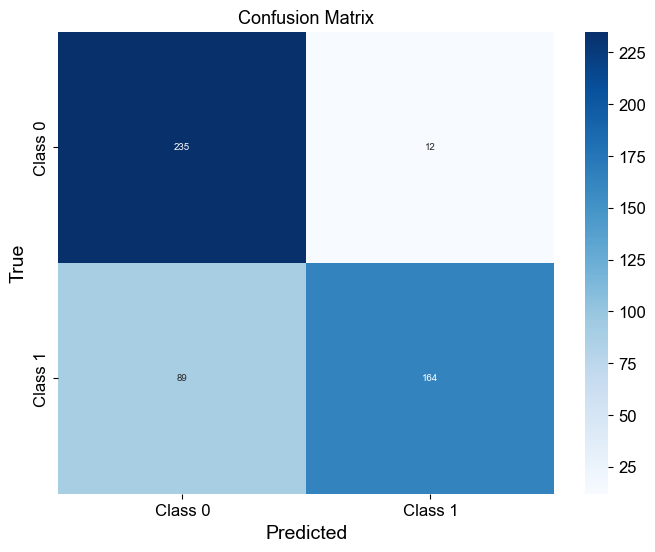

              precision    recall  f1-score   support

     Class 0       0.73      0.95      0.82       247
     Class 1       0.93      0.65      0.76       253

    accuracy                           0.80       500
   macro avg       0.83      0.80      0.79       500
weighted avg       0.83      0.80      0.79       500



In [9]:
# Collect predictions and ground truths
predicted_choices = []
true_labels = []

for trial in range(num_trials):
    env0.new_trial()
    observations, ground_truth = env0.ob, env0.gt
    inputs = torch.from_numpy(observations[:, np.newaxis, :]).type(torch.float)
    predictions, hidden_states = model(inputs, task_idx=0)

    # Evaluate performance
    predictions = predictions.detach().numpy()
    decision = np.argmax(predictions[-1, 0, :])
    is_correct = decision == ground_truth[-1]

    # Store predictions and ground truth
    predicted_choices.append(decision)
    true_labels.append(ground_truth[-1])


from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_choices)

print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(conf_matrix, class_names=['Class 0', 'Class 1'])

from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_choices, target_names=['Class 0', 'Class 1']))


Confusion Matrix:
[[257   0]
 [  0 243]]


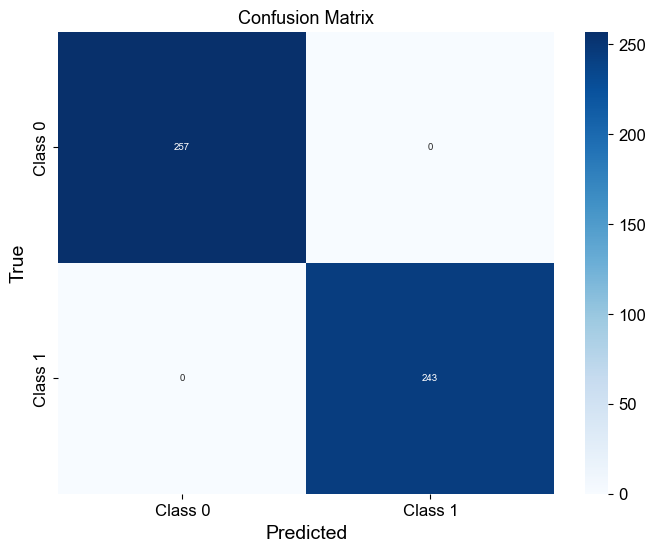

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       257
     Class 1       1.00      1.00      1.00       243

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



In [10]:
# Collect predictions and ground truths for Task 1
predicted_choices = []
true_labels = []

for trial in range(num_trials):
    env1.new_trial()
    observations, ground_truth = env1.ob, env1.gt
    inputs = torch.from_numpy(observations[:, np.newaxis, :]).type(torch.float)
    predictions, hidden_states = model(inputs, task_idx=1)

    # Evaluate performance
    predictions = predictions.detach().numpy()
    decision = np.argmax(predictions[-1, 0, :])
    is_correct = decision == ground_truth[-1]

    # Store predictions and ground truth
    predicted_choices.append(decision)
    true_labels.append(ground_truth[-1])


from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_choices)

print("Confusion Matrix:")
print(conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot with class names (e.g., 0 and 1 for binary classification)
plot_confusion_matrix(conf_matrix, class_names=['Class 0', 'Class 1'])

from sklearn.metrics import classification_report

print(classification_report(true_labels, predicted_choices, target_names=['Class 0', 'Class 1']))
